## Variant Calling Report v1.2.3
## Input Parameters

In [1]:
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import numpy as np
import nexusplt as nxp
from configparser import ConfigParser

pd.options.display.float_format = '{:,.2%}'.format
pd.set_option('display.max_colwidth', None)

configFile='/data/ug_hcr_report_debug/var_report.config'
parser = ConfigParser()
parser.read(configFile)

prmNames=['run_id','pipeline_version',
          'h5_concordance_file', 'h5_model_file',
          'model_name_with_gt','model_name_without_gt','model_pkl_with_gt','model_pkl_without_gt'
         ]

prm={}
for name in prmNames:
    prm[name]=parser.get('VarReport', name)

h5outfile = parser.get('VarReport', 'h5_output', fallback='var_report.h5')
imgpref = parser.get('VarReport', 'image_output_prefix', fallback=prm['run_id']+'.vars')+'.'
imgdir = 'plots'

sources = {'Trained wo gt':(prm['h5_concordance_file'],"concordance"),
           'Trained with gt':(prm['h5_model_file'],"scored_concordance"),
          }

data = {}
for s in sources:
    data[s]={}
    d=pd.read_hdf(sources[s][0], key=sources[s][1], mode='r')
    data[s]=d

with pd.HDFStore(prm['h5_concordance_file']) as hdf:
    keys=hdf.keys()
    wg_dfs=[pd.read_hdf(hdf,k) for k in keys if k not in ['/concordance','/input_args']]
    wg_df=pd.concat(wg_dfs)
    
data['whole genome'] = wg_df
sources['whole genome'] = (prm['h5_concordance_file'],"all")
    
prm['mean_var_depth']='{:.2f}'.format(data['Trained wo gt']['well_mapped_coverage'].mean())
prmNames.append('mean_var_depth')
   
try:
    args=pd.read_hdf(sources['Trained wo gt'][0], 'input_args', mode='r')
    prm['truth_sample_name']=args['truth_sample_name'][0]
except:
    prm['truth_sample_name']=parser.get('VarReport', 'truth_sample_name', fallback='NA')
prmNames.append('truth_sample_name')


prmdf = pd.DataFrame.from_dict(prm, orient='index',columns=['value']).reindex(prmNames)
prmdf.to_hdf(h5outfile, key="parameters")

prmdf

,value
run_id,004788-X0032
pipeline_version,3.2.3
h5_concordance_file,/data/ug_hcr_report_debug/004788-X0032.comp.h5
h5_model_file,/data/ug_hcr_report_debug/004788-X0032.model.h5
model_name_with_gt,threshold_model_ignore_gt_incl_hpol_runs
model_name_without_gt,rf_model_ignore_gt_incl_hpol_runs
model_pkl_with_gt,004788-X0032.model.withgt.h5
model_pkl_without_gt,004788-X0032.model.nogt.pkl
mean_var_depth,64.28
truth_sample_name,INTEGRATION


In [38]:
%matplotlib inline

In [3]:
def filterByCategory(data,cat):
    if cat=='SNP':
        return data[data['indel']==False]
    elif cat=='non-hmer Indel':
        return data[(data['indel']==True) & (data['hmer_indel_length']==0) & (data['indel_length']>0)]
    elif cat=='non-hmer Indel w/o LCR':
        return data[(data['indel']==True) & (data['hmer_indel_length']==0) & (data['indel_length']>0) & 
                    (~data['LCR-hs38'])]
    elif cat=='hmer Indel <=4':
        return data[(data['indel']==True) & (data['hmer_indel_length']>0) & (data['hmer_indel_length']<=4)]
    elif cat=='hmer Indel >4,<=8':
        return data[(data['indel']==True) & (data['hmer_indel_length']>4) & (data['hmer_indel_length']<=8)]
    elif cat=='hmer Indel >8,<=10':
        return data[(data['indel']==True) & (data['hmer_indel_length']>8) & (data['hmer_indel_length']<=10)]
    for i in range (1,10):
        if cat=='hmer Indel {0:d}'.format(i):
            return data[(data['indel']==True) & (data['hmer_indel_length']==i)]
    return None


In [4]:
def calcPerformance(data, gt=False):
    classify='classify_gt' 
    d=data.copy()
    
    d['tree_score'] = np.where(d[classify]=='fn',-1,d['tree_score'])
    d=d[[classify,'tree_score','filter']].sort_values(by=['tree_score'])
    
    d['label'] = np.where(d[classify]=='fp',0,1)

    d.loc[d['filter']=='HPOL_RUN','filter']='PASS'
    d.loc[d['filter']=='COHORT_FP','filter']='PASS'
    d.loc[d[classify]=='fn','filter']='MISS'
    d['class'] = np.where(d['label']==0,'FP','FN')
    d.loc[(d['label']==1) & (d['filter']=='PASS'),'class']='TP'
    d.loc[(d['label']==0) & (d['filter']!='PASS'),'class']='TN'

    num=len(d)
    numPos=sum(d['label'])
    numNeg=num-numPos
    if num<10:
        return (pd.DataFrame(),None,numPos,numNeg)
    
    d['fn']=np.cumsum(d['label'])
    d['tp']=numPos-(d['fn'])
    d['fp']=numNeg-np.cumsum(1-d['label'])

    d['recall']=d['tp']/(d['tp']+d['fn'])
    d['precision']=d['tp']/(d['tp']+d['fp'])

    d['f1']=d['tp']/(d['tp']+0.5*d['fn']+0.5*d['fp'])

    d['mask']=((d['tp']+d['fn'])>=20) & ((d['tp']+d['fp'])>=20) & (d['tree_score']>=0)
    if len(d[d['mask']])==0:
        return (pd.DataFrame(),None,numPos,numNeg)

    # The model value
    fn=len(d[d['class']=='FN'])
    tp=len(d[d['class']=='TP'])
    fp=len(d[d['class']=='FP'])

    recall=tp/(tp+fn) if (tp+fn>0) else np.nan
    precision=tp/(tp+fp) if (tp+fp>0) else np.nan
    max_recall=1-len(d[d['filter']=='MISS'])/numPos

    f1=tp/(tp+0.5*fn+0.5*fp)
    
    return (d[['recall','precision']][d['mask']],
            dict({'recall':recall,'precision':precision,'f1':f1}),
            numPos,numNeg)



In [5]:
def plotPerformance(perfCurve,optRes,categories,source=sources,ext=None,img=None):
    n=len(categories)
    fig, ax = plt.subplots(1,n,figsize=(4*n,4))
    col=['r','b','g','m','k']

    for i,cat in enumerate(categories):
        for j,s in enumerate(source):
            perf=perfCurve[s][cat]
            opt=optRes[s][cat]
            if not perf.empty:
                ax[i].plot(perf.recall,perf.precision,'-',label=s,color=col[j])    
                ax[i].plot(opt.get('recall'),opt.get('precision'),'o',color=col[j])
            title=cat if ext==None else '{0} ({1})'.format(cat,ext)
            ax[i].set_title(title)
            ax[i].set_xlabel("Recall")
            ax[i].set_xlim([0.4,1])
            ax[i].set_ylim([0.4,1])
            ax[i].grid(True)

    ax[0].set_ylabel("Precision")
    ax[0].legend(loc='lower left')
    
    if img:
        nxp.save(fig,imgpref+img,'png',outdir=imgdir)
    
    
def getPerformance(data,categories,gt=False):
    optTab={}
    optRes={}
    perfCurve={}
    for s in sources:
        optTab[s]=pd.DataFrame()
        optRes[s]={}
        perfCurve[s]={}

        for i,cat in enumerate(categories):
            d=filterByCategory(data[s],cat)
            perf,opt,pos,neg=calcPerformance(d,gt)
            perfCurve[s][cat]=perf
            optRes[s][cat]=opt
            
            row=pd.DataFrame({'# pos':pos,
                              '# neg':neg,
                              'max recall':np.nan if perf.empty else max(perf.recall),
                              'recall':np.nan if perf.empty else opt.get('recall'),
                              'precision':np.nan if perf.empty else opt.get('precision'),
                              'F1':np.nan if perf.empty else opt.get('f1')
                             },index=[cat])
            optTab[s]=pd.concat([optTab[s],row])
            
    return optTab,optRes,perfCurve

## Performance over all Data

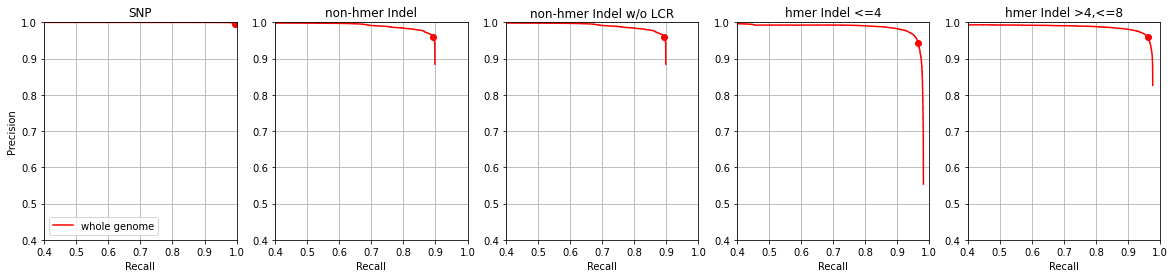

In [6]:
categories=['SNP','non-hmer Indel','non-hmer Indel w/o LCR','hmer Indel <=4','hmer Indel >4,<=8']
optTab1,optRes,perfCurve=getPerformance(data,categories)
plotPerformance(perfCurve,optRes,categories,img='all.primary',source={'whole genome':sources['whole genome']})

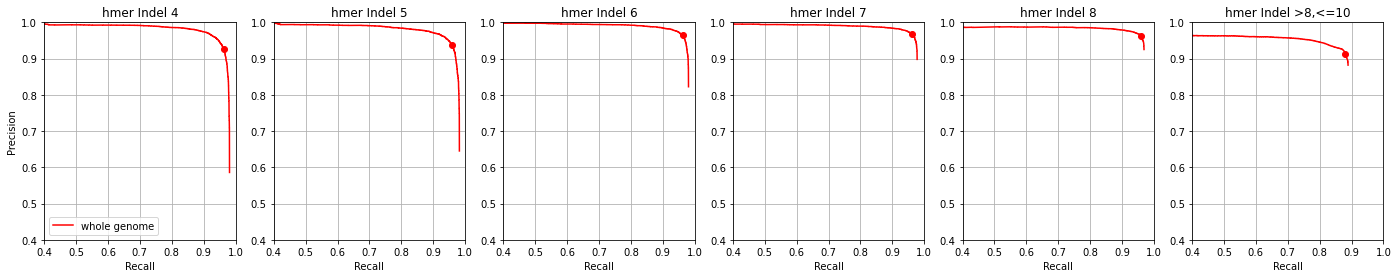

In [7]:
categories=['hmer Indel 4','hmer Indel 5','hmer Indel 6','hmer Indel 7','hmer Indel 8','hmer Indel >8,<=10']
optTab2,optRes,perfCurve=getPerformance(data,categories)
plotPerformance(perfCurve,optRes,categories,img='all.hmers',source={'whole genome':sources['whole genome']})

In [8]:
pd.options.display.float_format = '{:,.2%}'.format

optTab={}
for s in sources:
    optTab[s]=pd.concat([optTab1[s], optTab2[s]])
df=pd.concat([optTab[s] for s in sources], axis=1, keys=[s for s in sources])
df.to_hdf(h5outfile, key="all_data")
df_all=df
df['whole genome']

,# pos,# neg,max recall,recall,precision,F1
SNP,2980250,25800,99.52%,99.49%,99.58%,99.54%
non-hmer Indel,177001,20725,89.83%,89.31%,95.95%,92.51%
non-hmer Indel w/o LCR,177001,20725,89.83%,89.31%,95.95%,92.51%
hmer Indel <=4,52675,41676,98.16%,96.53%,94.27%,95.39%
"hmer Indel >4,<=8",38931,8008,97.67%,96.08%,96.00%,96.04%
hmer Indel 4,8882,6162,98.12%,96.28%,92.65%,94.43%
hmer Indel 5,7215,3898,98.21%,95.95%,93.77%,94.85%
hmer Indel 6,9524,2019,98.07%,96.22%,96.47%,96.35%
hmer Indel 7,10620,1182,97.77%,96.30%,96.78%,96.54%
hmer Indel 8,11572,909,96.92%,95.85%,96.31%,96.08%


### Homozygous genotyping accuracy

In [11]:
categories=['SNP','non-hmer Indel','non-hmer Indel w/o LCR','hmer Indel <=4','hmer Indel >4,<=8']

hmzData={}
for s in sources:
        d=data[s]
        hmzData[s]=d[(d['gt_ground_truth']==(1,1)) & (d['classify_gt']!='fn')]
optTab,optRes,perfCurve=getPerformance(hmzData,categories,gt=True)
df=pd.concat([optTab[s] for s in sources], axis=1, keys=[s for s in sources])
df.to_hdf(h5outfile, key="all_data_homozygous")
df['whole genome']

,# pos,# neg,max recall,recall,precision,F1
SNP,1283872,13,100.00%,100.00%,100.00%,100.00%
non-hmer Indel,58377,131,100.00%,99.85%,99.78%,99.82%
non-hmer Indel w/o LCR,58377,131,100.00%,99.85%,99.78%,99.82%
hmer Indel <=4,24586,29,100.00%,99.96%,99.89%,99.92%
"hmer Indel >4,<=8",14242,9,99.99%,99.93%,99.94%,99.94%


## Performance over UG high confidence regions

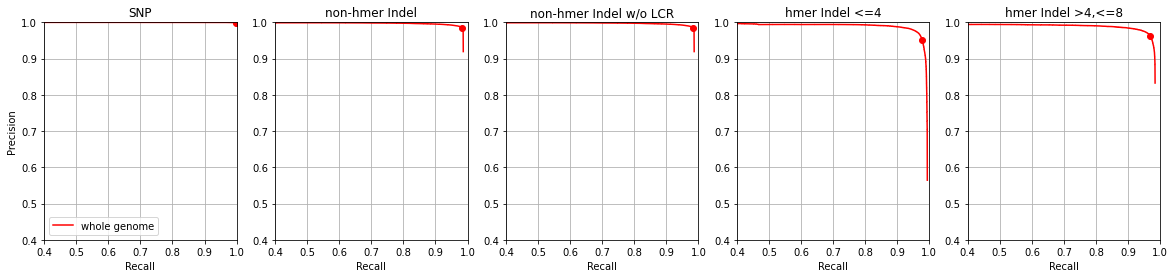

In [12]:
filtData={}
for s in sources:
    d=data[s]
    filtData[s]=d.query("ug_hcr==True")

categories=['SNP','non-hmer Indel','non-hmer Indel w/o LCR','hmer Indel <=4','hmer Indel >4,<=8']
optTab1,optRes,perfCurve=getPerformance(filtData,categories)
plotPerformance(perfCurve,optRes,categories,img='hicvg.primary',source={'whole genome':sources['whole genome']})

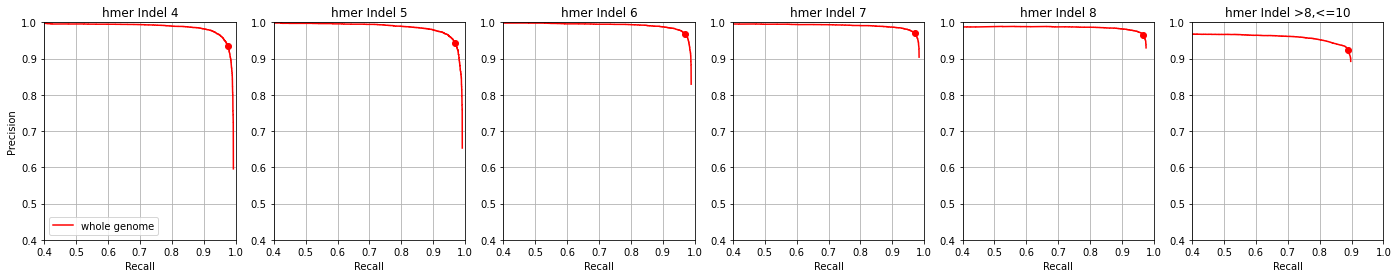

In [13]:
categories=['hmer Indel 4','hmer Indel 5','hmer Indel 6','hmer Indel 7','hmer Indel 8','hmer Indel >8,<=10']
optTab2,optRes,perfCurve=getPerformance(filtData,categories)
plotPerformance(perfCurve,optRes,categories,img='hicvg.hmers',source={'whole genome':sources['whole genome']})

In [14]:
optTab={}
for s in sources:
    optTab[s]=pd.concat([optTab1[s], optTab2[s]])
df=pd.concat([optTab[s] for s in sources], axis=1, keys=[s for s in sources])
df.to_hdf(h5outfile, key="ug_hcr")
defTable=df.copy()
df['whole genome']

,# pos,# neg,max recall,recall,precision,F1
SNP,2936835,17685,99.82%,99.80%,99.76%,99.78%
non-hmer Indel,142384,12325,98.68%,98.25%,98.46%,98.36%
non-hmer Indel w/o LCR,142384,12325,98.68%,98.25%,98.46%,98.36%
hmer Indel <=4,51332,39368,99.38%,97.80%,95.01%,96.39%
"hmer Indel >4,<=8",37993,7522,98.40%,96.85%,96.36%,96.61%
hmer Indel 4,8647,5826,99.33%,97.57%,93.45%,95.47%
hmer Indel 5,7051,3711,99.12%,96.91%,94.34%,95.61%
hmer Indel 6,9297,1892,98.90%,97.12%,96.76%,96.94%
hmer Indel 7,10381,1086,98.38%,96.97%,97.11%,97.04%
hmer Indel 8,11264,833,97.57%,96.49%,96.65%,96.57%


### Homozygous genotyping accuracy

In [17]:
categories=['SNP','non-hmer Indel','non-hmer Indel w/o LCR','hmer Indel <=4','hmer Indel >4,<=8']

hmzData={}
for s in sources:
        d=filtData[s]
        hmzData[s]=d[(d['gt_ground_truth']==(1,1)) & (d['classify_gt']!='fn')]
optTab,optRes,perfCurve=getPerformance(hmzData,categories,gt=True)
df=pd.concat([optTab[s] for s in sources], axis=1, keys=[s for s in sources])
df.to_hdf(h5outfile, key="ug_hcr_homozygous")
df['whole genome']

categories=['SNP','non-hmer Indel','non-hmer Indel w/o LCR','hmer Indel <=4','hmer Indel >4,<=8']

### Stratified by base

#### (A,T)

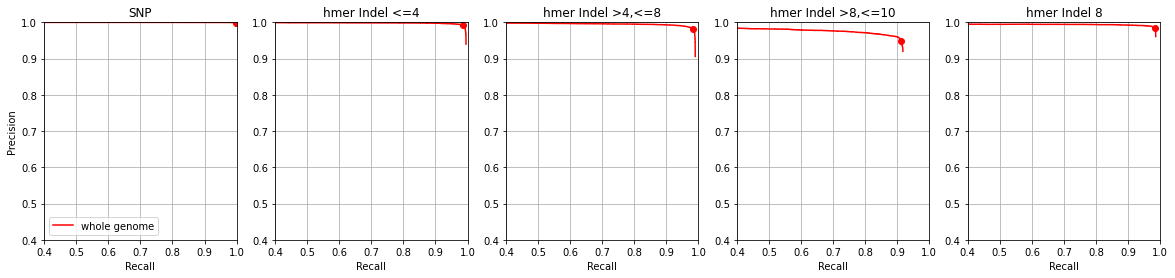

In [18]:
categories=['SNP','hmer Indel <=4','hmer Indel >4,<=8','hmer Indel >8,<=10','hmer Indel 8']

baseData={}
b =('A','T')
for s in sources:
        d=filtData[s]
        baseData[s]=d[((d['indel']==False) & ((d['ref']==b[0]) | (d['ref']==b[1]))) |
                      ((d['hmer_indel_length']>0) & ((d['hmer_indel_nuc']==b[0]) | (d['hmer_indel_nuc']==b[1])))
                     ]
optTab1,optRes,perfCurve=getPerformance(baseData,categories)
for s in sources:
    optTab1[s].rename(index={a:'{0} ({1}/{2})'.format(a,b[0],b[1]) for a in optTab1[s].index}, inplace=True)
plotPerformance(perfCurve,optRes,categories,source={'whole genome':sources['whole genome']})

#### (G,C)

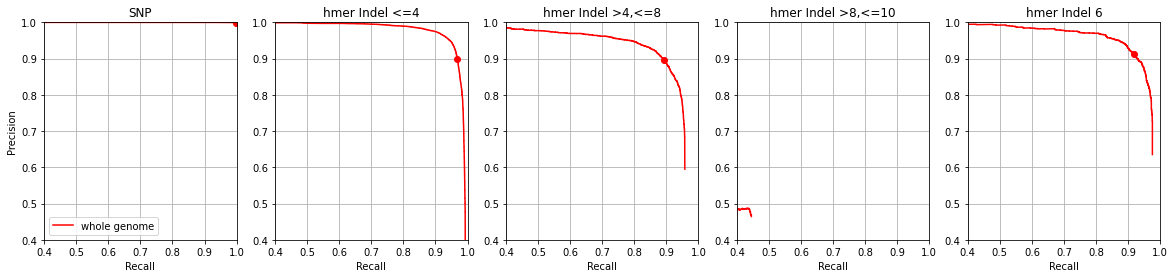

In [19]:
categories=['SNP','hmer Indel <=4','hmer Indel >4,<=8','hmer Indel >8,<=10','hmer Indel 6']
baseData={}
b =('C','G')
for s in sources:
        d=filtData[s]
        baseData[s]=d[((d['indel']==False) & ((d['ref']==b[0]) | (d['ref']==b[1]))) |
                      ((d['hmer_indel_length']>0) & ((d['hmer_indel_nuc']==b[0]) | (d['hmer_indel_nuc']==b[1])))
                     ]
optTab2,optRes,perfCurve=getPerformance(baseData,categories)
for s in sources:
    optTab2[s].rename(index={a:'{0} ({1}/{2})'.format(a,b[0],b[1]) for a in optTab2[s].index}, inplace=True)
plotPerformance(perfCurve,optRes,categories,source={'whole genome':sources['whole genome']})

In [20]:
optTab={}
for s in sources:
    optTab[s]=pd.concat([optTab1[s], optTab2[s]])
df=pd.concat([optTab[s] for s in sources], axis=1, keys=[s for s in sources])
df.to_hdf(h5outfile, key="ug_hcr_per_base")
df['whole genome']

,# pos,# neg,max recall,recall,precision,F1
SNP (A/T),1413627,12758,99.84%,99.81%,99.74%,99.78%
hmer Indel <=4 (A/T),31607,2008,99.53%,98.49%,99.19%,98.84%
"hmer Indel >4,<=8 (A/T)",31646,3254,99.02%,98.45%,98.07%,98.26%
"hmer Indel >8,<=10 (A/T)",26121,2074,91.77%,91.11%,94.83%,92.93%
hmer Indel 8 (A/T),10278,413,98.62%,98.35%,98.45%,98.40%
SNP (C/G),1523208,4927,99.81%,99.79%,99.78%,99.79%
hmer Indel <=4 (C/G),19693,37007,99.30%,96.85%,89.93%,93.26%
"hmer Indel >4,<=8 (C/G)",6320,4121,95.76%,89.27%,89.61%,89.44%
"hmer Indel >8,<=10 (C/G)",1112,572,44.51%,39.03%,48.60%,43.29%
hmer Indel 6 (C/G),1848,1036,97.56%,91.77%,91.38%,91.58%


## Performance over regions with coverage>=20 and mappability.0

In [ ]:
filtData={}
for s in sources:
    d=data[s]
    filtData[s]=d[(d['well_mapped_coverage']>=20) &
                  (d['mappability.0'])
                 ]

categories=['SNP','non-hmer Indel','non-hmer Indel w/o LCR','hmer Indel <=4','hmer Indel >4,<=8']
optTab1,optRes,perfCurve=getPerformance(filtData,categories)
plotPerformance(perfCurve,optRes,categories,img='hicvg.primary',source={'whole genome':sources['whole genome']})


In [ ]:
categories=['hmer Indel 4','hmer Indel 5','hmer Indel 6','hmer Indel 7','hmer Indel 8','hmer Indel >8,<=10']
optTab2,optRes,perfCurve=getPerformance(filtData,categories)
plotPerformance(perfCurve,optRes,categories,img='hicvg.hmers',source={'whole genome':sources['whole genome']})

In [ ]:
optTab={}
for s in sources:
    optTab[s]=pd.concat([optTab1[s], optTab2[s]])
df=pd.concat([optTab[s] for s in sources], axis=1, keys=[s for s in sources])
df.to_hdf(h5outfile, key="good_cvg_data")
defTable=df.copy()
df['whole genome']

### Including genotype

In [ ]:
categories=['SNP','non-hmer Indel','non-hmer Indel w/o LCR','hmer Indel <=4','hmer Indel >4,<=8']
optTab,optRes,perfCurve=getPerformance(filtData,categories,gt=True)
plotPerformance(perfCurve,optRes,categories,source={'whole genome':sources['whole genome']})

In [ ]:
df=pd.concat([optTab[s] for s in sources], axis=1, keys=[s for s in sources])
df.to_hdf(h5outfile, key="good_cvg_data_gt")
df['whole genome']

### Homozygous genotyping accuracy

In [ ]:
categories=['SNP','non-hmer Indel','non-hmer Indel w/o LCR','hmer Indel <=4','hmer Indel >4,<=8']

hmzData={}
for s in sources:
        d=filtData[s]
        hmzData[s]=d[(d['gt_ground_truth']==(1,1)) & (d['classify_gt']!='fn')]
optTab,optRes,perfCurve=getPerformance(hmzData,categories,gt=True)
df=pd.concat([optTab[s] for s in sources], axis=1, keys=[s for s in sources])
df.to_hdf(h5outfile, key="good_cvg_data_homozygous")
df['whole genome']

### Stratified by base

#### (A,T)

In [ ]:
categories=['SNP','hmer Indel <=4','hmer Indel >4,<=8','hmer Indel >8,<=10','hmer Indel 8']

baseData={}
b =('A','T')
for s in sources:
        d=filtData[s]
        baseData[s]=d[((d['indel']==False) & ((d['ref']==b[0]) | (d['ref']==b[1]))) |
                      ((d['hmer_indel_length']>0) & ((d['hmer_indel_nuc']==b[0]) | (d['hmer_indel_nuc']==b[1])))
                     ]
optTab1,optRes,perfCurve=getPerformance(baseData,categories)
for s in sources:
    optTab1[s].rename(index={a:'{0} ({1}/{2})'.format(a,b[0],b[1]) for a in optTab1[s].index}, inplace=True)
plotPerformance(perfCurve,optRes,categories,source={'whole genome':sources['whole genome']})

#### (G,C)

In [ ]:
categories=['SNP','hmer Indel <=4','hmer Indel >4,<=8','hmer Indel >8,<=10','hmer Indel 6']
baseData={}
b =('C','G')
for s in sources:
        d=filtData[s]
        baseData[s]=d[((d['indel']==False) & ((d['ref']==b[0]) | (d['ref']==b[1]))) |
                      ((d['hmer_indel_length']>0) & ((d['hmer_indel_nuc']==b[0]) | (d['hmer_indel_nuc']==b[1])))
                     ]
optTab2,optRes,perfCurve=getPerformance(baseData,categories)
for s in sources:
    optTab2[s].rename(index={a:'{0} ({1}/{2})'.format(a,b[0],b[1]) for a in optTab2[s].index}, inplace=True)
plotPerformance(perfCurve,optRes,categories,source={'whole genome':sources['whole genome']})

In [ ]:
optTab={}
for s in sources:
    optTab[s]=pd.concat([optTab1[s], optTab2[s]])
df=pd.concat([optTab[s] for s in sources], axis=1, keys=[s for s in sources])
df.to_hdf(h5outfile, key="good_cvg_data_per_base")
df['whole genome']

###  Trained with and without Ground Truth

In [ ]:
categories=['SNP','non-hmer Indel','non-hmer Indel w/o LCR','hmer Indel <=4','hmer Indel >4,<=8']
optTab1,optRes,perfCurve=getPerformance(data,categories)
plotPerformance(perfCurve,optRes,categories,img='all.primary',source={'Trained wo gt':sources['Trained wo gt'], 'Trained with gt': sources['Trained wo gt']})

## Performance over regions with coverage>=20 and mappability.0

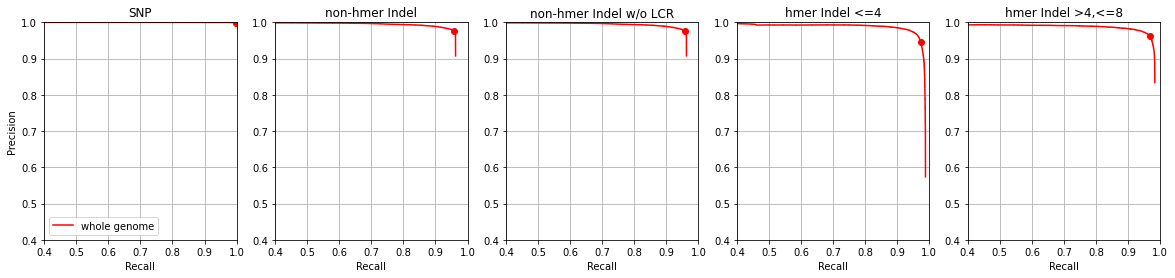

In [21]:
filtData={}
for s in sources:
    d=data[s]
    filtData[s]=d[(d['well_mapped_coverage']>=20) &
                  (d['mappability.0'])
                 ]

categories=['SNP','non-hmer Indel','non-hmer Indel w/o LCR','hmer Indel <=4','hmer Indel >4,<=8']
optTab1,optRes,perfCurve=getPerformance(filtData,categories)
plotPerformance(perfCurve,optRes,categories,img='hicvg.primary',source={'whole genome':sources['whole genome']})


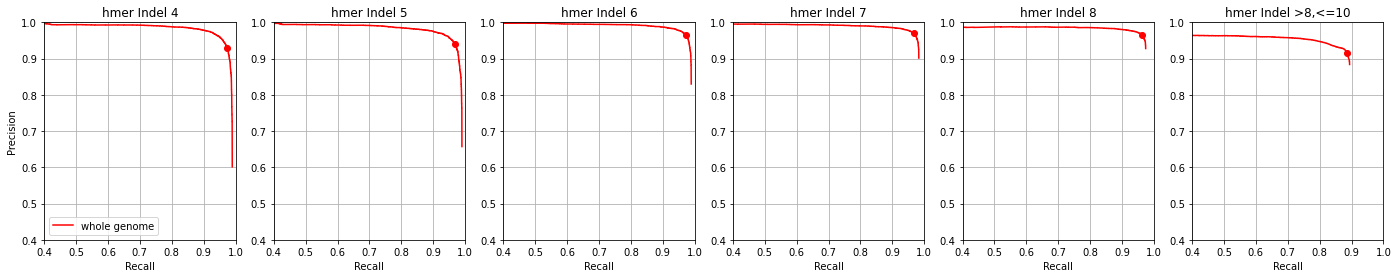

In [22]:
categories=['hmer Indel 4','hmer Indel 5','hmer Indel 6','hmer Indel 7','hmer Indel 8','hmer Indel >8,<=10']
optTab2,optRes,perfCurve=getPerformance(filtData,categories)
plotPerformance(perfCurve,optRes,categories,img='hicvg.hmers',source={'whole genome':sources['whole genome']})

In [23]:
optTab={}
for s in sources:
    optTab[s]=pd.concat([optTab1[s], optTab2[s]])
df=pd.concat([optTab[s] for s in sources], axis=1, keys=[s for s in sources])
df.to_hdf(h5outfile, key="good_cvg_data")
defTable=df.copy()
df['whole genome']

,# pos,# neg,max recall,recall,precision,F1
SNP,2925783,16766,99.80%,99.78%,99.76%,99.77%
non-hmer Indel,160997,15806,96.28%,95.74%,97.60%,96.66%
non-hmer Indel w/o LCR,160997,15806,96.28%,95.74%,97.60%,96.66%
hmer Indel <=4,51798,38024,98.81%,97.29%,94.61%,95.93%
"hmer Indel >4,<=8",38248,7517,98.32%,96.81%,96.19%,96.50%
hmer Indel 4,8697,5708,98.98%,97.32%,93.02%,95.12%
hmer Indel 5,7056,3645,99.01%,96.84%,94.05%,95.43%
hmer Indel 6,9242,1874,98.92%,97.21%,96.62%,96.91%
hmer Indel 7,10491,1128,98.29%,96.89%,96.95%,96.92%
hmer Indel 8,11459,870,97.44%,96.39%,96.49%,96.44%


### Including genotype

In [ ]:
categories=['SNP','non-hmer Indel','non-hmer Indel w/o LCR','hmer Indel <=4','hmer Indel >4,<=8']
optTab,optRes,perfCurve=getPerformance(filtData,categories,gt=True)
plotPerformance(perfCurve,optRes,categories,source={'whole genome':sources['whole genome']})

In [ ]:
df=pd.concat([optTab[s] for s in sources], axis=1, keys=[s for s in sources])
df.to_hdf(h5outfile, key="good_cvg_data_gt")
df['whole genome']

### Homozygous genotyping accuracy

In [26]:
categories=['SNP','non-hmer Indel','non-hmer Indel w/o LCR','hmer Indel <=4','hmer Indel >4,<=8']

hmzData={}
for s in sources:
        d=filtData[s]
        hmzData[s]=d[(d['gt_ground_truth']==(1,1)) & (d['classify_gt']!='fn')]
optTab,optRes,perfCurve=getPerformance(hmzData,categories,gt=True)
df=pd.concat([optTab[s] for s in sources], axis=1, keys=[s for s in sources])
df.to_hdf(h5outfile, key="good_cvg_data_homozygous")
df['whole genome']

,# pos,# neg,max recall,recall,precision,F1
SNP,1263105,8,100.00%,100.00%,100.00%,100.00%
non-hmer Indel,56778,47,100.00%,99.85%,99.92%,99.88%
non-hmer Indel w/o LCR,56778,47,100.00%,99.85%,99.92%,99.88%
hmer Indel <=4,24345,27,100.00%,99.97%,99.89%,99.93%
"hmer Indel >4,<=8",14091,9,99.99%,99.95%,99.94%,99.95%


### Stratified by base

#### (A,T)

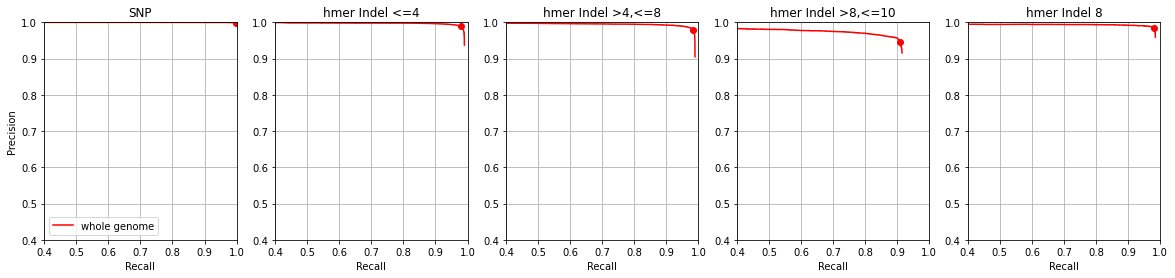

In [27]:
categories=['SNP','hmer Indel <=4','hmer Indel >4,<=8','hmer Indel >8,<=10','hmer Indel 8']

baseData={}
b =('A','T')
for s in sources:
        d=filtData[s]
        baseData[s]=d[((d['indel']==False) & ((d['ref']==b[0]) | (d['ref']==b[1]))) |
                      ((d['hmer_indel_length']>0) & ((d['hmer_indel_nuc']==b[0]) | (d['hmer_indel_nuc']==b[1])))
                     ]
optTab1,optRes,perfCurve=getPerformance(baseData,categories)
for s in sources:
    optTab1[s].rename(index={a:'{0} ({1}/{2})'.format(a,b[0],b[1]) for a in optTab1[s].index}, inplace=True)
plotPerformance(perfCurve,optRes,categories,source={'whole genome':sources['whole genome']})

#### (G,C)

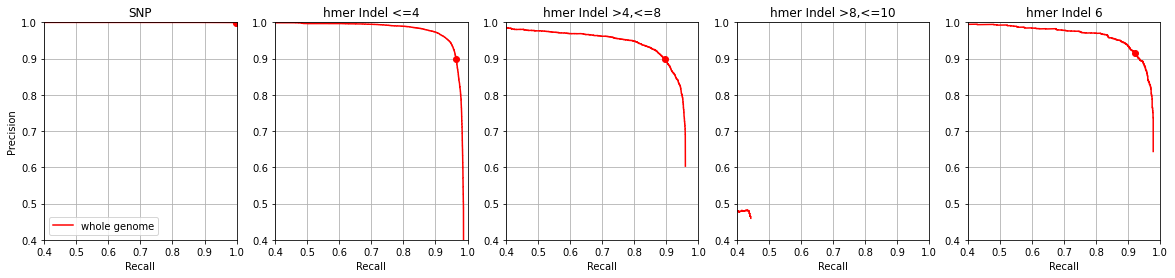

In [28]:
categories=['SNP','hmer Indel <=4','hmer Indel >4,<=8','hmer Indel >8,<=10','hmer Indel 6']
baseData={}
b =('C','G')
for s in sources:
        d=filtData[s]
        baseData[s]=d[((d['indel']==False) & ((d['ref']==b[0]) | (d['ref']==b[1]))) |
                      ((d['hmer_indel_length']>0) & ((d['hmer_indel_nuc']==b[0]) | (d['hmer_indel_nuc']==b[1])))
                     ]
optTab2,optRes,perfCurve=getPerformance(baseData,categories)
for s in sources:
    optTab2[s].rename(index={a:'{0} ({1}/{2})'.format(a,b[0],b[1]) for a in optTab2[s].index}, inplace=True)
plotPerformance(perfCurve,optRes,categories,source={'whole genome':sources['whole genome']})

In [29]:
optTab={}
for s in sources:
    optTab[s]=pd.concat([optTab1[s], optTab2[s]])
df=pd.concat([optTab[s] for s in sources], axis=1, keys=[s for s in sources])
df.to_hdf(h5outfile, key="good_cvg_data_per_base")
df['whole genome']

,# pos,# neg,max recall,recall,precision,F1
SNP (A/T),1414668,12299,99.79%,99.77%,99.73%,99.75%
hmer Indel <=4 (A/T),31914,2120,99.03%,98.00%,98.86%,98.43%
"hmer Indel >4,<=8 (A/T)",31896,3315,98.94%,98.39%,98.00%,98.19%
"hmer Indel >8,<=10 (A/T)",26790,2254,91.49%,90.85%,94.44%,92.61%
hmer Indel 8 (A/T),10468,440,98.49%,98.20%,98.38%,98.29%
SNP (C/G),1511115,4467,99.81%,99.79%,99.79%,99.79%
hmer Indel <=4 (C/G),19823,35372,98.77%,96.43%,89.94%,93.07%
"hmer Indel >4,<=8 (C/G)",6303,3979,95.94%,89.53%,89.76%,89.64%
"hmer Indel >8,<=10 (C/G)",1121,586,44.34%,38.89%,48.02%,42.98%
hmer Indel 6 (C/G),1836,995,97.82%,92.21%,91.56%,91.89%


###  Trained with and without Ground Truth

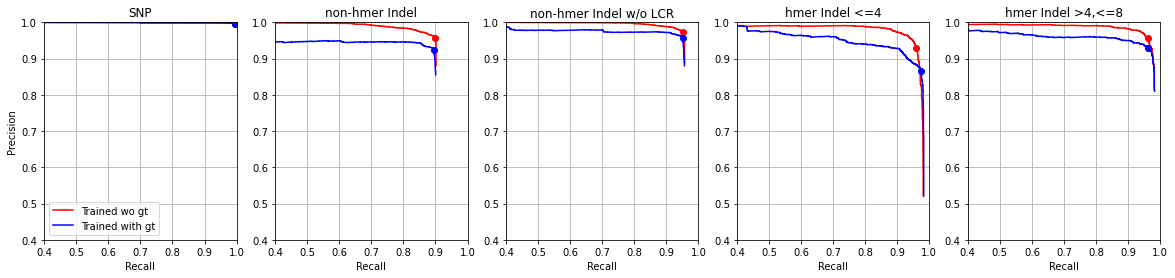

In [30]:
categories=['SNP','non-hmer Indel','non-hmer Indel w/o LCR','hmer Indel <=4','hmer Indel >4,<=8']
optTab1,optRes,perfCurve=getPerformance(data,categories)
plotPerformance(perfCurve,optRes,categories,img='all.primary',source={'Trained wo gt':sources['Trained wo gt'], 'Trained with gt': sources['Trained wo gt']})

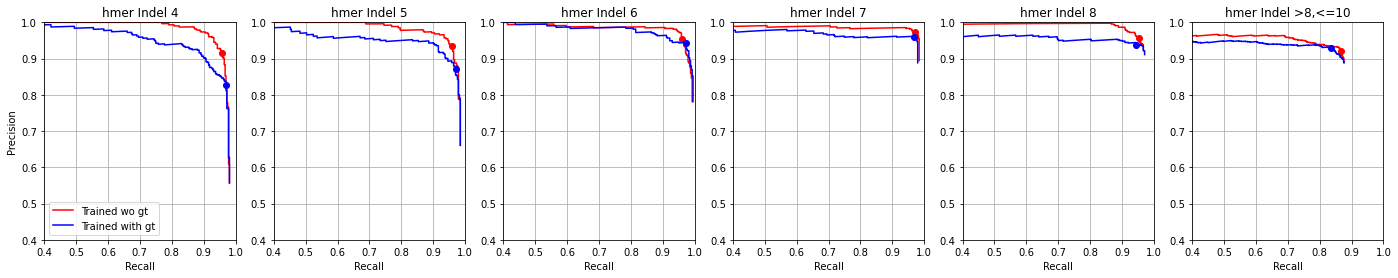

In [31]:
categories=['hmer Indel 4','hmer Indel 5','hmer Indel 6','hmer Indel 7','hmer Indel 8','hmer Indel >8,<=10']
optTab2,optRes,perfCurve=getPerformance(data,categories)
plotPerformance(perfCurve,optRes,categories,img='all.hmers',source={'Trained wo gt':sources['Trained wo gt'], 'Trained with gt': sources['Trained wo gt']})

In [32]:
pd.options.display.float_format = '{:,.2%}'.format
sources={'Trained wo gt':sources['Trained wo gt'], 'Trained with gt': sources['Trained wo gt']}
optTab={}
for s in sources:
    optTab[s]=pd.concat([optTab1[s], optTab2[s]])
df=pd.concat([optTab[s] for s in sources], axis=1, keys=[s for s in sources])
df.to_hdf(h5outfile, key="trained_w_wo_gt")
df_all=df
df

Trained wo gt                                           \
                               # pos # neg max recall recall precision     F1   
SNP                           130683  1177     99.55% 99.52%    99.51% 99.52%   
non-hmer Indel                  7400   908     90.19% 89.78%    95.82% 92.70%   
non-hmer Indel w/o LCR          5484   665     95.70% 95.30%    97.21% 96.24%   
hmer Indel <=4                  2123  1920     98.12% 95.76%    93.04% 94.38%   
hmer Indel >4,<=8               1644   369     98.11% 96.05%    95.58% 95.81%   
hmer Indel 4                     368   286     98.10% 95.65%    91.43% 93.49%   
hmer Indel 5                     334   170     98.50% 95.81%    93.57% 94.67%   
hmer Indel 6                     385   108     99.22% 96.10%    95.36% 95.73%   
hmer Indel 7                     438    52     98.40% 97.03%    97.25% 97.14%   
hmer Indel 8                     487    39     96.71% 95.28%    95.67% 95.47%   
hmer Indel >8,<=10              1160   125     87.59% 86.81%    91.96% 89.31%   

                       Trained with gt                                    \
                                 # pos # neg max recall recall precision   
SNP                             130683  1177     99.55% 99.48%    99.50%   
non-hmer Indel                    7410  1130     90.07% 89.46%    92.36%   
non-hmer Indel w/o LCR            5488   714     95.63% 95.08%    95.57%   
hmer Indel <=4                    2120  1915     98.25% 97.50%    86.67%   
hmer Indel >4,<=8                 1642   379     98.23% 96.29%    93.00%   
hmer Indel 4                       368   289     98.10% 97.01%    82.64%   
hmer Indel 5                       334   170     98.50% 97.01%    87.10%   
hmer Indel 6                       384   108     99.48% 97.40%    94.21%   
hmer Indel 7                       439    54     97.95% 96.81%    95.94%   
hmer Indel 8                       485    47     97.11% 94.43%    93.85%   
hmer Indel >8,<=10                1159   129     87.66% 83.52%    92.90%   

                               
                           F1  
SNP                    99.49%  
non-hmer Indel         90.89%  
non-hmer Indel w/o LCR 95.32%  
hmer Indel <=4         91.76%  
hmer Indel >4,<=8      94.61%  
hmer Indel 4           89.25%  
hmer Indel 5           91.78%  
hmer Indel 6           95.77%  
hmer Indel 7           96.37%  
hmer Indel 8           94.14%  
hmer Indel >8,<=10     87.96%

In [40]:
%matplotlib agg
d=defTable['Trained with gt'][['max recall','recall','precision']]
labels=['SNP','nhmer','nhmer w/o LCR','hmer 2-4','hmer 5-8','hmer 4','hmer 5','hmer 6','hmer 7','hmer 8','hmer 9-10']
fig=plt.figure()
ax=d.plot()
plt.xticks(np.arange(len(d.index)), rotation=30, ha='right')
ax.set_xticklabels(labels)
plt.ylim([0.4,1.05])
plt.grid()
plt.title('Cvg>20X, Trained variant calls')
plt.tight_layout()
nxp.save(fig,imgpref+'summary','png',outdir=imgdir)
plt.close(fig)